In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec
import spacy
from sklearn.decomposition import PCA
from matplotlib import pyplot

In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [4]:
df=pd.read_csv('got_scripts_breakdown.csv', sep=';')
df.head()

,Column1,Season,Episode,Sentence,Name,N_serie,N_Season,Emision Date
0,1,Season 1,winter is coming,What d’you expect? They’re savages One lot ste...,waymar royce,1,1,17/04/2011
1,2,Season 1,winter is coming,I’ve never seen wildlings do a thing like this...,will,1,1,17/04/2011
2,3,Season 1,winter is coming,How close did you get?,waymar royce,1,1,17/04/2011
3,4,Season 1,winter is coming,Close as any man would,will,1,1,17/04/2011
4,5,Season 1,winter is coming,We should head back to the wall,gared,1,1,17/04/2011


In [5]:
# Convert to list
data = df.Sentence.values.tolist()

In [6]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['what', 'you', 'expect', 'they', 're', 'savages', 'one', 'lot', 'steals', 'goat', 'from', 'another', 'lot', 'and', 'before', 'you', 'know', 'it', 'they', 're', 'ripping', 'each', 'other', 'to', 'pieces']]


In [7]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['what', 'you', 'expect', 'they', 're', 'savages', 'one', 'lot', 'steals', 'goat', 'from', 'another', 'lot', 'and', 'before', 'you', 'know', 'it', 'they', 're', 'ripping', 'each_other', 'to', 'pieces']


In [8]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['expect', 'savage', 'lot', 'steal', 'goat', 'lot', 'know', 'rip', 'piece']]


In [9]:
# train model
model = Word2Vec(data_lemmatized, min_count=1)
# summarize the loaded model
print(model)
# summarize vocabulary
words = list(model.wv.vocab)
print(words[:100])
# access vector for one word
print(model['winter'])


Word2Vec(vocab=6995, size=100, alpha=0.025)
['expect', 'savage', 'lot', 'steal', 'goat', 'know', 'rip', 'piece', 'never', 'see', 'wildling', 'thing', 'ever', 'life', 'close', 'get', 'man', 'would', 'head', 'back', 'wall', 'dead', 'frighten', 'order', 'track', 'trouble', 'think', 'ask', 'die', 'horse', 'could', 'even', 'kill', 'child', 'good', 'want', 'run', 'away', 'south', 'course', 'behead', 'deserter', 'catch', 'first', 'say', 'seem', 'move', 'camp', 'go', 'father', 'watch', 'mother', 'fine', 'work', 'always', 'well', 'do', 'thank', 'love', 'detail', 'manage', 'corner', 'quite', 'beautiful', 'stitching', 'marksman', 'keep', 'practice', 'bran', 'much', 'relax', 'bow', 'arm', 'jon', 'quick', 'faster', 'lord', 'stark', 'lady', 'guardsman', 'ride', 'hill', 'capture', 'night', 'lad', 'saddle', 'swear', 'oath', 'cat', 'law', 'tell', 'come', 'ne', 'young', 'boy', 'forever', 'winter', 'rest', 'white_walker', 'break']
[-0.52438384 -0.12308876  0.19384149  0.22253199 -0.07213442 -0.24344973
 

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


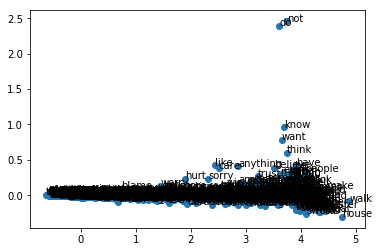

In [10]:
X = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
pyplot.scatter(result[:, 0], result[:, 1])
words = list(model.wv.vocab)
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

In [13]:
sim_words = model.wv.most_similar('throne')
print(sim_words)

[('uncle', 0.9999086856842041), ('crown', 0.9999064207077026), ('red', 0.9999010562896729), ('perhaps', 0.999900221824646), ('stanni', 0.99989914894104), ('become', 0.9998987317085266), ('drogon', 0.999896764755249), ('lead', 0.9998967051506042), ('moment', 0.9998962879180908), ('begin', 0.999894917011261)]
